# Laboratorium 2


### Konfiguracja

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
import math
import time
import copy
import pickle

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [32]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    

### Przykład użycia

<IPython.core.display.Javascript object>


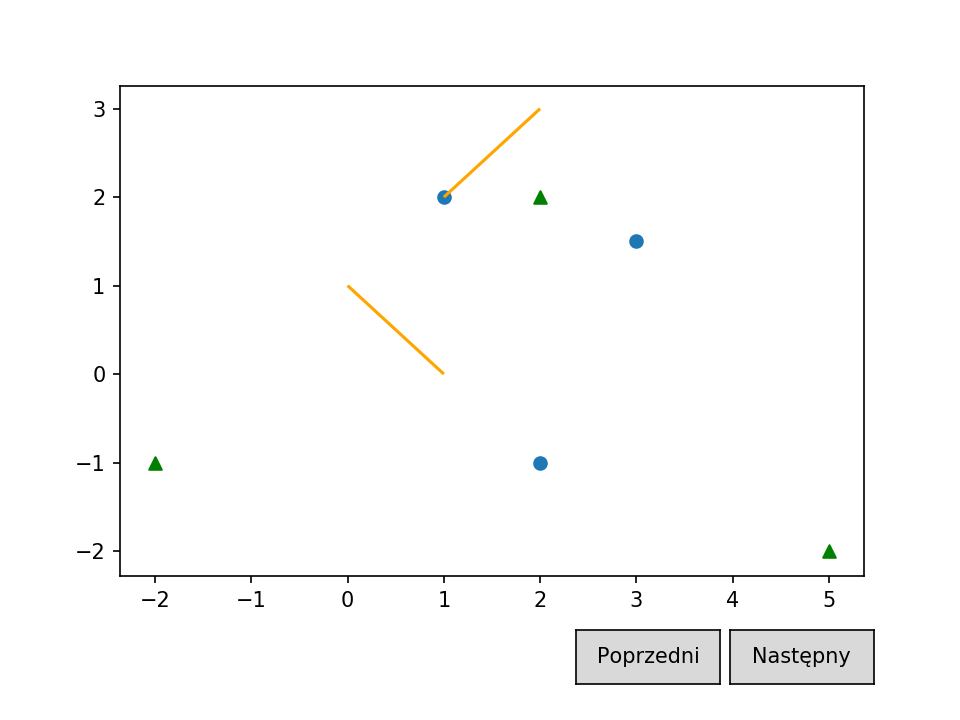

In [33]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], 'green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]], 'orange')]), 
        Scene([PointsCollection([(1, 2), (-15, 1.5), (2, -1)], 'red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], 'black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


### Rozwiązanie

In [34]:
def det_2(a, b, c):
    return ((a[0] - c[0]) * (b[1] - c[1])) - ((a[1] - c[1]) * (b[0] - c[0]))


def rand_P(n, point_range1, point_range2):
    return [[random.uniform(point_range1, point_range2), random.uniform(point_range1, point_range2)] for i in range(n)]


def rand_point_cycle(R, t, x, y):
    return [R * math.cos((math.pi / 2) * t) + x, R * math.sin((math.pi / 2) * t) + y]


def points_cycle(n, R, x, y):
    return [rand_point_cycle(R, random.uniform(0, 4), x, y) for i in range(n)]


def rand_line(n, point_range1, point_range2, a, b):
    if a[0] == b[0]:
        return [[a[0], random.uniform(a[1], b[1])] for i in range(n)]
    res = []
    for i in range(n):
        x = random.uniform(point_range1, point_range2)
        y = (a[1] - b[1]) / (a[0] - b[0]) * x + (a[1] - (a[1] - b[1]) / (a[0] - b[0]) * a[0])
        res.append([x, y])
    return res


def side(left, right, bot, top):
    side = random.uniform(0, 4)
    if side < 1:
        return [right, random.uniform(bot, top)]
    elif side < 2:
        return [left, random.uniform(bot, top)]
    elif side < 3:
        return [random.uniform(left, right), top]
    return [random.uniform(left, right), bot]


def rectangle(n, left, right, bottom, top):
    return [side(left, right, bottom, top) for i in range(n)]


def rectangle_with_diagonals(n, p, leftB, rightB, rightT, leftT):
    side1 = rand_line(n, leftB[0], rightB[0], leftB, rightB)
    side2 = rand_line(n, leftB[0], leftT[0], leftB, leftT)
    diagonal1 = rand_line(p, leftB[0], rightB[0], leftB, rightT)
    diagonal2 = rand_line(p, leftB[0], rightB[0], rightB, leftT)
    result = diagonal1 + diagonal2 + side1 + side2
    return result


def pickle_hall(hall):
    f = open('result.txt', 'wb')
    pickle.dump(hall, f)
    f.close()

In [35]:
rectangle = rectangle(100, 0, 7, 2, 10)
rectangle2 = rectangle_with_diagonals(25, 20, (0,0), (10,0), (10,10), (0,10))
cycle = points_cycle(100, 10, 5, 6)
plane = rand_P(100, -100, 100)
eps = 10 ** -8

<IPython.core.display.Javascript object>


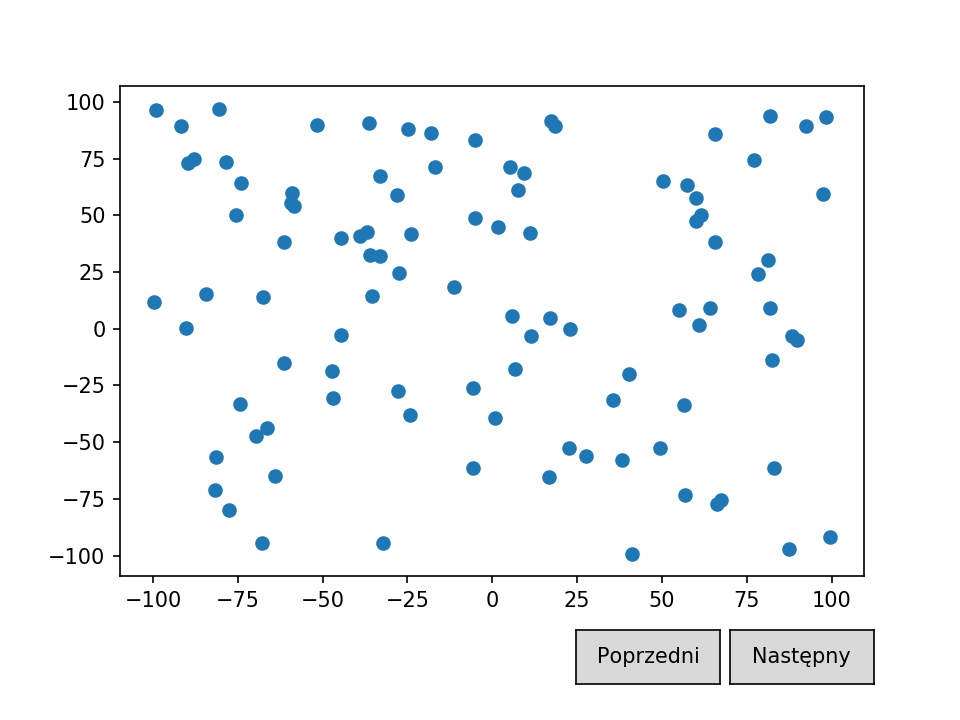

In [36]:
%matplotlib notebook

scenes = [Scene([PointsCollection(plane)]),
         Scene([PointsCollection(cycle)]),
         Scene([PointsCollection(rectangle)]),
         Scene([PointsCollection(rectangle2)])]

plot= Plot(scenes)
plot.draw()

### Graham Algorithm

In [37]:
def border_draft(points):
    return [[[points[i][0], points[i][1]], [points[i + 1][0], points[i + 1][1]]] for i in range(len(points) - 1)]


def angle(point):
    if point[1] == 0:
        return -9999999
    return - point[0] / point[1]


def distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

In [38]:
def sort_graham(points):
    staring_points = copy.deepcopy(points)
    orient = staring_points[0]
    for point in staring_points:
        if (orient[1] > point[1]
                or (orient[1] == point[1] and orient[0] > point[0])):
            orient = point
    (x, y) = orient
    for point in staring_points:
        point[0] -= x
        point[1] -= y
    return sorted(staring_points, key=lambda x: (angle(x), distance(x, [0, 0]))), x, y


def filter(points):
    filtered_points = [points[0]]
    for i in range(1, len(points) - 2):
        if not -eps < det_2(points[i-1], points[i], points[i+1])< eps:
            filtered_points.append(points[i])
    filtered_points.append(points[-1])
    return filtered_points


def graham(points, visualization=False):
    start = time.time()
    sorted_points, starting_x, starting_y = sort_graham(points)
    scenes = [Scene([PointsCollection(sorted_points, 'red')])]
    filtered_points = filter(sorted_points)
    scenes.append(Scene([PointsCollection(filtered_points, 'red')]))

    stack = [filtered_points[0], filtered_points[1], filtered_points[2]]
    i = 3
    while i < len(filtered_points):
        t = len(stack) - 1
        if visualization:
            scenes.append(Scene([PointsCollection(filtered_points, 'red'),
                                PointsCollection(stack, 'purple'),
                                PointsCollection([stack[t-1], stack[t], filtered_points[i]], 'green')],
                                [LinesCollection(border_draft(stack), 'purple'),
                                 LinesCollection(border_draft([stack[t - 1], stack[t], filtered_points[i]]),
                                                 'green'), ]))
        if det_2(stack[t - 1], stack[t], filtered_points[i]) > eps:
            stack.append(filtered_points[i])
            i = i + 1
        else:
            stack.pop()
    for point in stack:
        point[0] += starting_x
        point[1] += starting_y
    print(f'Graham alghoritm: {time.time() - start}s')
    scenes.append(Scene([PointsCollection(points, 'red'),
                        PointsCollection(stack, 'purple')],
                        [LinesCollection(border_draft(stack + [stack[0]]), 'purple')]))
    return stack, scenes

### Jarvis Algorithm

In [39]:
def jarvis(points, visualization=False):
    start = time.time()
    scenes = [Scene([PointsCollection(points, 'red')])]
    border_index = 0
    n = len(points)
    for i in range(1, n):
        if (points[border_index][1] > points[i][1]
                or (points[border_index][1] == points[i][1] and points[border_index][0] > points[i][0])):
            border_index = i
    start_point = border_index
    result = []
    processing_point = points[border_index]
    while True:
        result.append(processing_point)
        next_point_index = (border_index + 1) % n
        next_point = points[next_point_index]
        for i in range(n):
            if visualization: scenes.append(Scene([PointsCollection(points, 'red'),
                                                   PointsCollection([processing_point, next_point], 'green'),
                                                  PointsCollection(result, 'purple')],
                                          [LinesCollection(border_draft(result), 'purple'),
                                           LinesCollection(border_draft([processing_point, points[i]]), 'green'),
                                           LinesCollection(border_draft([processing_point, next_point]), 'blue')]))
            if det_2(processing_point, points[i], next_point) > eps or \
                    (-eps < det_2(processing_point, points[i], next_point) < eps
                    and (distance(processing_point, points[i]) > distance(processing_point, next_point))):
                next_point_index = i
                next_point = points[i]
        border_index = next_point_index
        processing_point = points[border_index]
        if border_index == start_point:
            break
    print(f'Jarvis {time.time() - start}s')
    scenes.append(Scene([PointsCollection(points, 'red'),
                         PointsCollection(result, 'purple')],
                            [LinesCollection(border_draft(result + [result[0]]), 'purple')]))
    return result, scenes

#### Graham results

In [40]:
graham_plane_result, gplane_scene = graham(plane)
graham_cycle_result, gcycle_scene = graham(cycle)
graham_rectangle_result, grectangle_scene = graham(rectangle)
graham_rectangle2_result, grectangle2_scene = graham(rectangle2)

Graham alghoritm: 0.003999233245849609s
Graham alghoritm: 0.0s
Graham alghoritm: 0.0039980411529541016s
Graham alghoritm: 0.0s


<IPython.core.display.Javascript object>


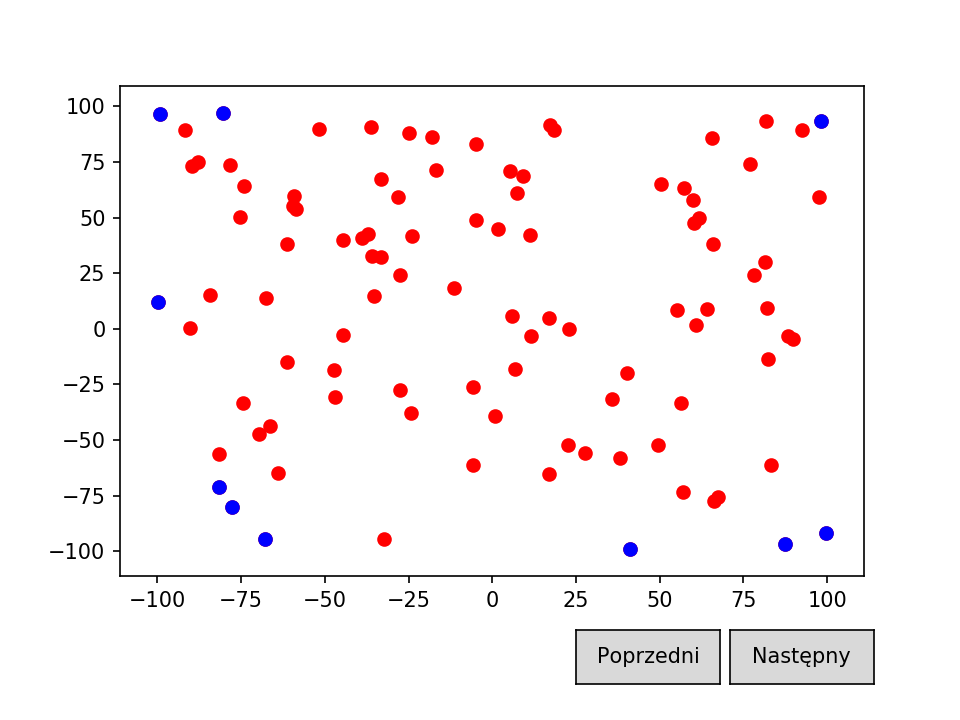

In [41]:
%matplotlib notebook

scenes=[Scene([PointsCollection(plane, 'red'), PointsCollection(graham_plane_result, 'blue')]),
        Scene([PointsCollection(cycle, 'red'), PointsCollection(graham_cycle_result, 'blue')]),
        Scene([PointsCollection(rectangle, 'red'), PointsCollection(graham_rectangle_result, 'blue')]),
        Scene([PointsCollection(rectangle2, 'red'), PointsCollection(graham_rectangle2_result, 'blue')]),
        ]
plot = Plot(scenes)
plot.draw()

#### Jarvis results

In [24]:
jarvis_plane_result, jplane_scene = jarvis(plane)
jarvis_cycle_result, jcycle_scene = jarvis(cycle)
jarvis_rectangle_result, jrectangle_scene = jarvis(rectangle)
jarvis_rectangle2_result, jrectangle2_scene = jarvis(rectangle2)

Jarvis 0.004000425338745117s
Jarvis 0.028005361557006836s
Jarvis 0.003999471664428711s
Jarvis 0.0s


<IPython.core.display.Javascript object>


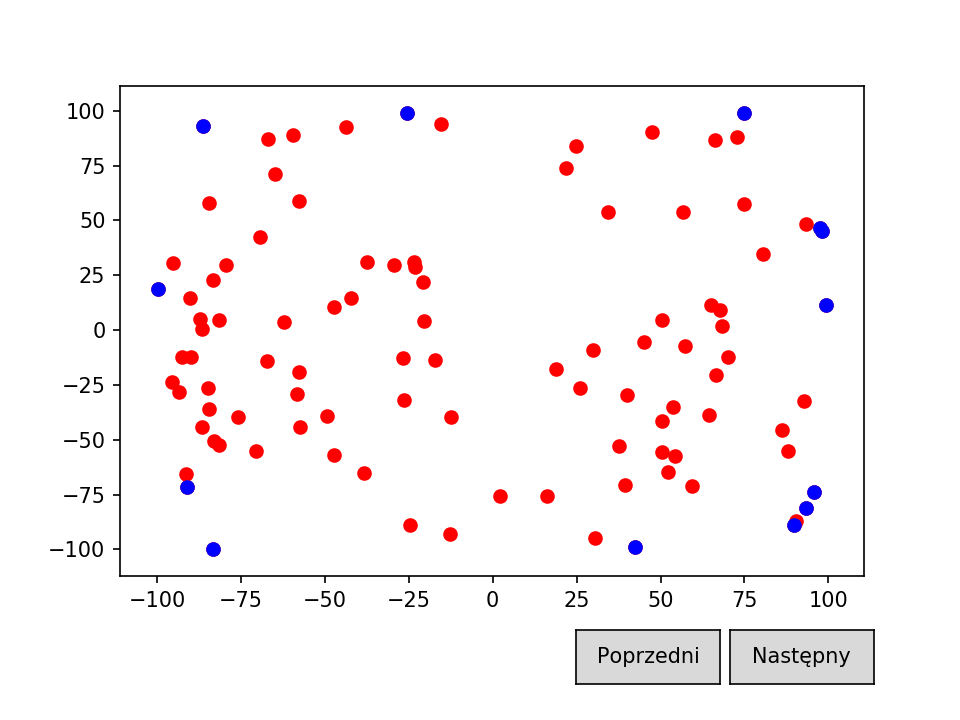

In [25]:
%matplotlib notebook

scenes=[Scene([PointsCollection(plane, 'red'), PointsCollection(jarvis_plane_result, 'blue')]),
        Scene([PointsCollection(cycle, 'red'), PointsCollection(jarvis_cycle_result, 'blue')]),
        Scene([PointsCollection(rectangle, 'red'), PointsCollection(jarvis_rectangle_result, 'blue')]),
        Scene([PointsCollection(rectangle2, 'red'), PointsCollection(jarvis_rectangle2_result, 'blue')]),
        ]
plot = Plot(scenes)
plot.draw()

#### Visualization

Graham alghoritm: 0.02799844741821289s


<IPython.core.display.Javascript object>


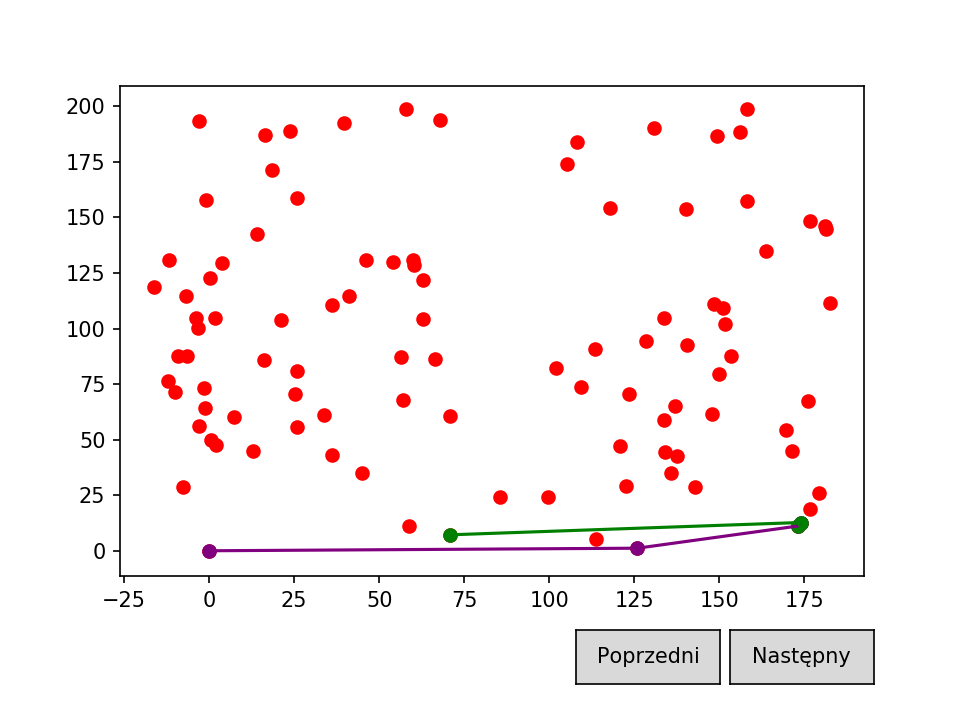

In [26]:
%matplotlib notebook   

results, scenes = graham(plane, visualization = True)

plot = Plot(scenes)
plot.draw()

Jarvis 0.20001482963562012s


<IPython.core.display.Javascript object>


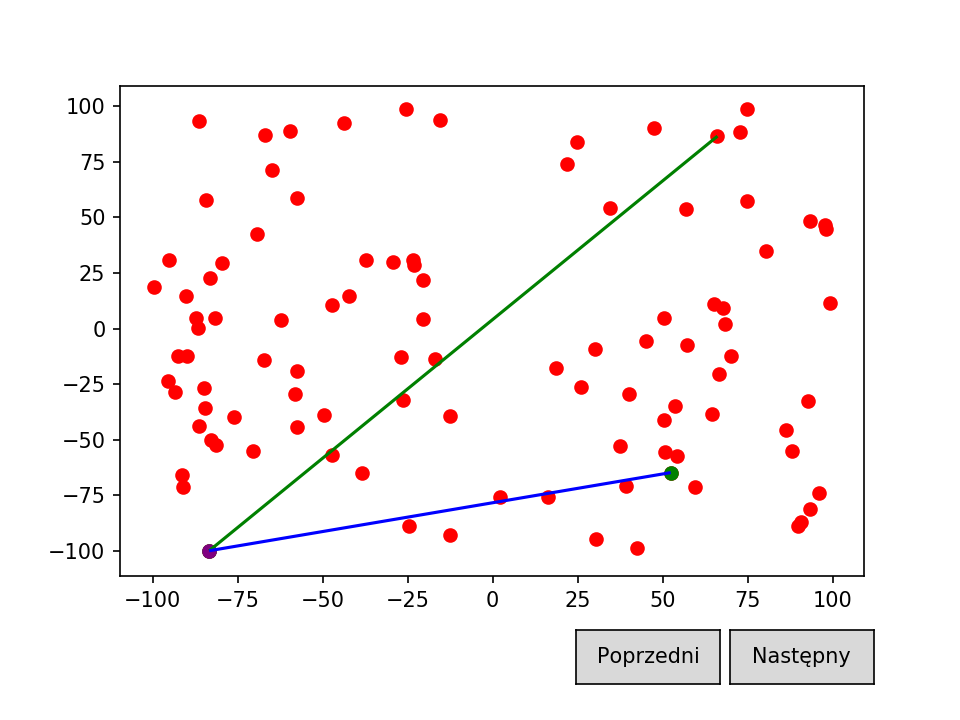

In [27]:
%matplotlib notebook   

results, scenes = jarvis(plane, visualization = True)

plot = Plot(scenes)
plot.draw()

Graham alghoritm: 0.0s


<IPython.core.display.Javascript object>


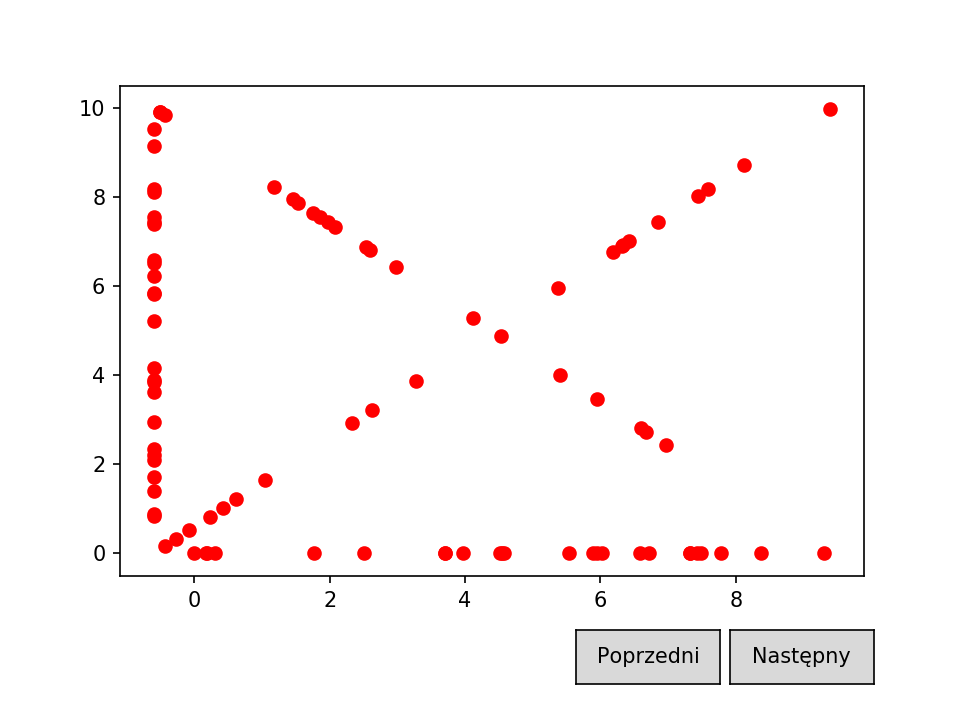

In [28]:
%matplotlib notebook   

results, scenes = graham(rectangle2, visualization = True)

plot = Plot(scenes)
plot.draw()

Jarvis 0.08000445365905762s


<IPython.core.display.Javascript object>


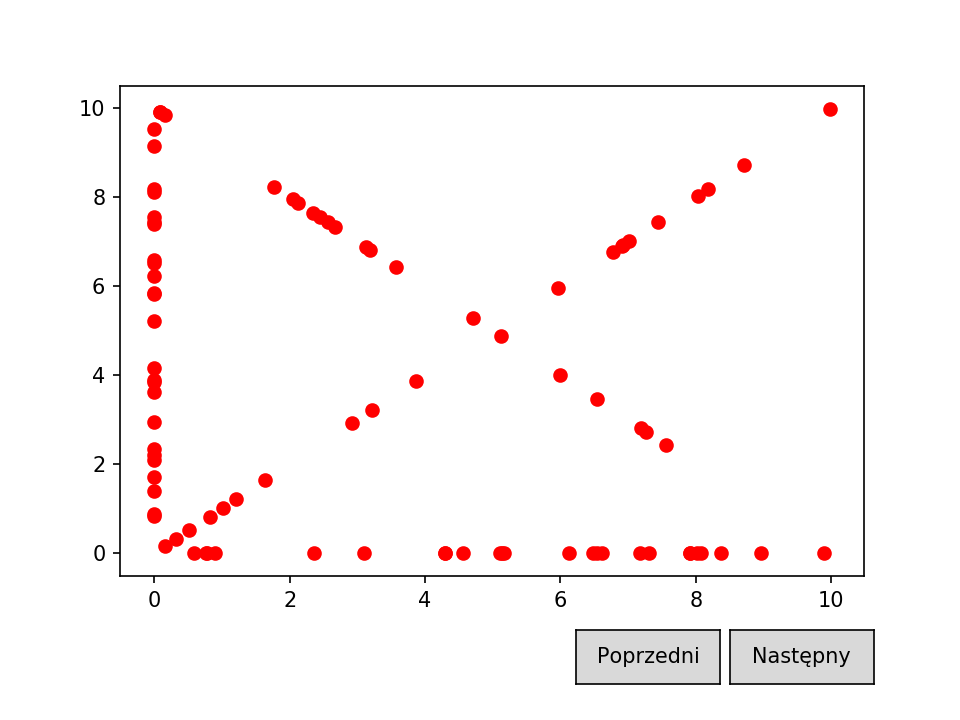

In [29]:
%matplotlib notebook   

results, scenes = jarvis(rectangle2, visualization = True)

plot = Plot(scenes)
plot.draw()

### Compare

In [30]:
Super_cloud = rand_P(100000, -300, 250)
Super_circle = points_cycle(1000, 100, 5, 7)
Super_rectangle = rectangle(100000, -100, 5000, 0, 10000)
Super_square = rectangle_with_diagonals(10000, 10000, (0,0), (50, 0), (50,50), (0,50))

print("Big cloud")
jarvis(Super_cloud)
graham(Super_cloud)
print("Big circle")
jarvis(Super_circle)
graham(Super_circle)
print("Big rectangle")
jarvis(Super_rectangle)
graham(Super_rectangle)
print("Big square with diagonals")
jarvis(Super_square)
graham(Super_square)

TypeError: 'list' object is not callable